In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf as sm_plot_acf, plot_pacf as sm_plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import linregress

import sys
print("Python:", sys.version.split()[0])
print("Matplotlib:", plt.matplotlib.__version__)

plt.rcParams.update({"figure.dpi": 120, "axes.grid": True})
SAVE_PLOTS = False  # set True if you want to save figures


Python: 3.11.5
Matplotlib: 3.8.3


Series length: 800


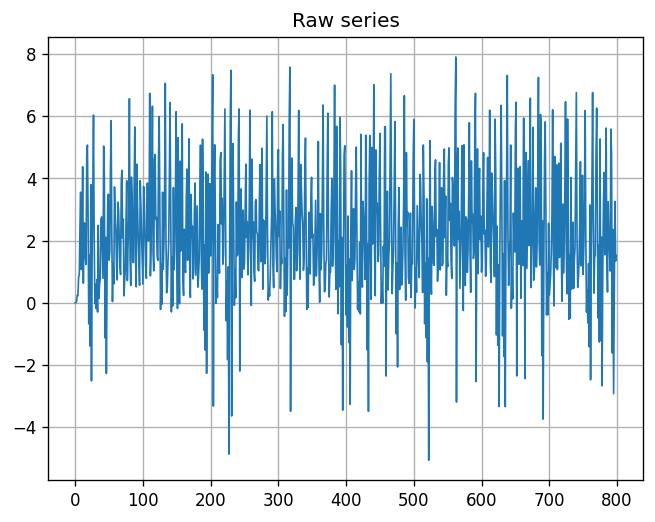

In [2]:
dat = pd.read_csv("DataPart5.csv")
y = dat.iloc[:, 0].astype(float).dropna().to_numpy()
print("Series length:", len(y))

pd.Series(y).plot(title="Raw series", lw=1)
plt.show()


,p,q,AIC,BIC
0,1,1,3448.985521,3467.723967
1,1,2,3422.714346,3446.137404
2,2,2,3424.342842,3452.450512


/Users/chrix/miniconda3/lib/python3.11/site-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/chrix/miniconda3/lib/python3.11/site-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/chrix/miniconda3/lib/python3.11/site-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


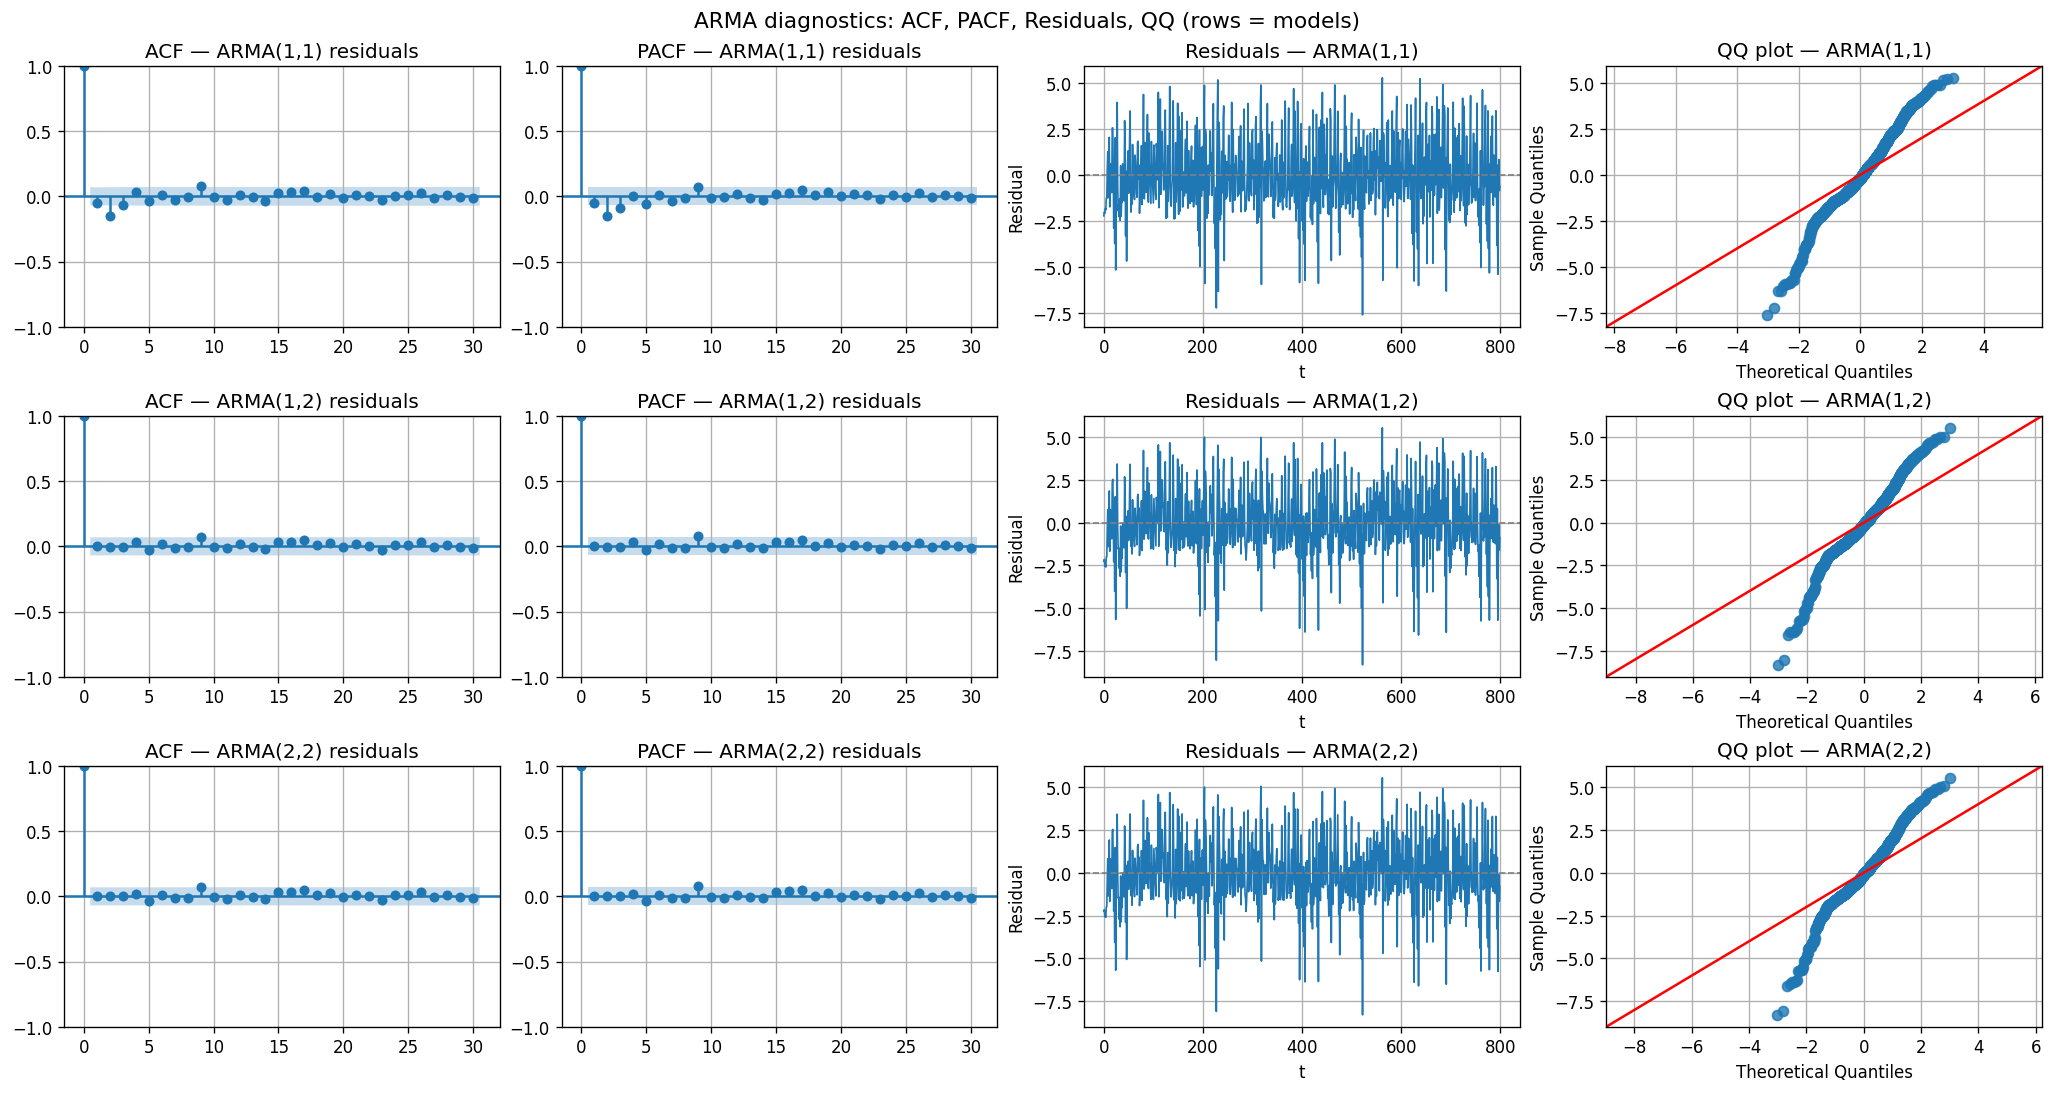

ARMA(1,1) Ljung-Box p-value @ lag 20: 0.018503501559966842
ARMA(1,2) Ljung-Box p-value @ lag 20: 0.9215499415495416
ARMA(2,2) Ljung-Box p-value @ lag 20: 0.9302936658472666


/var/folders/_m/4mgxhcdj4ns7lfq1pc_xf_3h0000gn/T/ipykernel_85588/4192661701.py:34: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"ARMA({p},{q}) Ljung-Box p-value @ lag 20:", float(lb['lb_pvalue']))


In [3]:
orders = [(1,1), (1,2), (2,2)]   # ARMA(p,q) candidates
models, residuals, info_rows = [], [], []

for (p, q) in orders:
    m = ARIMA(y, order=(p, 0, q)).fit()
    models.append(m)
    residuals.append(m.resid)
    info_rows.append({"p": p, "q": q, "AIC": m.aic, "BIC": m.bic})

display(pd.DataFrame(info_rows))

fig, axs = plt.subplots(nrows=len(orders), ncols=4, figsize=(17, 9), constrained_layout=True)
for i, ((p, q), resid) in enumerate(zip(orders, residuals)):
    sm_plot_acf(resid, lags=30, ax=axs[i, 0])
    axs[i, 0].set_title(f"ACF — ARMA({p},{q}) residuals")

    sm_plot_pacf(resid, lags=30, ax=axs[i, 1], method="ywm")
    axs[i, 1].set_title(f"PACF — ARMA({p},{q}) residuals")

    axs[i, 2].plot(resid, lw=1)
    axs[i, 2].axhline(0, ls="--", lw=1, color="gray")
    axs[i, 2].set_title(f"Residuals — ARMA({p},{q})")
    axs[i, 2].set_xlabel("t"); axs[i, 2].set_ylabel("Residual")

    qqplot(resid, line="45", ax=axs[i, 3], color="C1", alpha=0.8)
    axs[i, 3].set_title(f"QQ plot — ARMA({p},{q})")

fig.suptitle("ARMA diagnostics: ACF, PACF, Residuals, QQ (rows = models)", fontsize=13)
plt.show()

# Ljung–Box test @ lag 20 (white noise check)
for (p,q), resid in zip(orders, residuals):
    lb = acorr_ljungbox(resid, lags=[20], return_df=True)
    print(f"ARMA({p},{q}) Ljung-Box p-value @ lag 20:", float(lb['lb_pvalue']))


In [4]:
# Try Cleveland LOESS (degree=2) via scikit-misc; else fallback to statsmodels.lowess (degree=1).
try:
    from skmisc.loess import loess as _Loess
    _HAVE_SKMISC = True
except Exception:
    from statsmodels.nonparametric.smoothers_lowess import lowess as _lowess
    _HAVE_SKMISC = False
    print("scikit-misc not found — using statsmodels.lowess (degree=1) fallback.")

def _loess_predict(x_train, y_train, x_query, span=0.75, degree=2):
    span_eff = float(span)
    if span_eff <= 0: span_eff = 0.05
    if span_eff > 1:  span_eff = 1.0

    x_train = np.asarray(x_train, float)
    y_train = np.asarray(y_train, float)
    x_query = np.asarray(x_query, float)

    if _HAVE_SKMISC:
        model = _Loess(x_train, y_train, span=span_eff, degree=degree)
        model.fit()
        pred = model.predict(x_query, stderror=False).values
        return np.asarray(pred, float)
    else:
        fitted = _lowess(y_train, x_train, frac=span_eff, return_sorted=True)
        xs, ys = fitted[:,0], fitted[:,1]
        return np.interp(x_query, xs, ys, left=ys[0], right=ys[-1])

import pandas as pd

def leaveOneOut(D: pd.DataFrame, plotIt: bool=False) -> float:
    """
    R -> Python translation of leaveOneOut() used in ldf.R.
    D must have columns ['x','xk'] (x is response, xk is lagged predictor).
    Returns RSSk at the best span chosen by LOOCV.
    """
    if not isinstance(D, pd.DataFrame) or not {'x','xk'}.issubset(D.columns):
        raise ValueError("D must be a DataFrame with columns: 'x' and 'xk'")

    x  = D['x'].astype(float).to_numpy()
    xk = D['xk'].astype(float).to_numpy()
    n  = len(D)

    spans = list(np.round(np.arange(0.2, 1.0+1e-9, 0.1), 2)) + [2, 4, 10]
    R = np.full((n, len(spans)), np.nan)

    for jj, sp in enumerate(spans):
        print(f"  Fitting for bandwidth {jj+1} of {len(spans)} (span={sp})")
        for i in range(n):
            mask = np.ones(n, bool); mask[i] = False
            try:
                yhat_i = _loess_predict(xk[mask], x[mask], [xk[i]], span=sp, degree=2)[0]
            except Exception:
                yhat_i = np.nanmean(x[mask])
            R[i, jj] = x[i] - yhat_i

    RSSkAll = np.nansum(R**2, axis=0)
    j_best = int(np.nanargmin(RSSkAll))
    spanBest = spans[j_best]

    yhat_full = _loess_predict(xk, x, xk, span=spanBest, degree=2)
    RSSk = float(np.nansum((x - yhat_full)**2))

    if plotIt:
        order = np.argsort(xk)
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.scatter(D['xk'], D['x'], s=10, alpha=0.7)
        plt.plot(xk[order], yhat_full[order], color='crimson', lw=2,
                 label=f"LOESS (best span={spanBest})")
        plt.xlabel("xk"); plt.ylabel("x"); plt.title("Best span fit")
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(spans, RSSkAll, marker='o')
        plt.axvline(spanBest, color='crimson', ls='--', label='best span')
        plt.xlabel("span"); plt.ylabel("RSS (LOOCV)")
        plt.title("RSS vs span (LOOCV)")
        plt.legend(); plt.tight_layout(); plt.show()

    return RSSk


scikit-misc not found — using statsmodels.lowess (degree=1) fallback.


In [5]:
def ldf_with_leaveoneout(x, lags, n_boot=200, plot=True, plotFits=False):
    """
    LDF as in ldf.R:
      - For each lag k, compute LOOCV-selected LOESS RSS_k via leaveOneOut().
      - LDF(k) = (RSS - RSS_k)/RSS, where RSS is centered sum of squares of x_t.
      - Bootstrap an i.i.d. reference (k=1) to get 95% line.
    Returns (values, threshold).
    """
    x = np.asarray(x, float)
    vals = []

    for k in lags:
        print(f"Calculating LDF for lag {k}")
        D = pd.DataFrame({"x": x[k:], "xk": x[:-k]})
        RSSk = leaveOneOut(D, plotIt=plotFits)
        RSS  = np.sum((D['x'] - D['x'].mean())**2)
        vals.append((RSS - RSSk) / RSS)

    iid_vals = []
    for i in range(n_boot):
        if (i+1) % 20 == 0:
            print(f"  bootstrap {i+1}/{n_boot}")
        xr = np.random.choice(x, size=min(len(x), 100), replace=True)
        DR = pd.DataFrame({"x": xr[1:], "xk": xr[:-1]})
        RSSk = leaveOneOut(DR, plotIt=False)
        RSS  = np.sum((DR['x'] - DR['x'].mean())**2)
        iid_vals.append((RSS - RSSk) / RSS)

    thresh = float(np.quantile(iid_vals, 0.95))

    if plot:
        plt.figure(figsize=(7,4))
        plt.bar(lags, vals, width=0.6, color="C0", alpha=0.85)
        plt.axhline(thresh, color="blue", ls="--", label="95% conf. level (bootstrap)")
        plt.xlabel("Lag"); plt.ylabel("LDF value"); plt.title("Lag Dependence Function (LDF)")
        plt.legend(); plt.show()

    return np.array(vals), thresh


Selected by BIC: (1, 2) AIC: 3422.71434566903 BIC: 3446.1374043073697
Calculating LDF for lag 1
  Fitting for bandwidth 1 of 12 (span=0.2)
  Fitting for bandwidth 2 of 12 (span=0.3)
  Fitting for bandwidth 3 of 12 (span=0.4)
  Fitting for bandwidth 4 of 12 (span=0.5)
  Fitting for bandwidth 5 of 12 (span=0.6)
  Fitting for bandwidth 6 of 12 (span=0.7)
  Fitting for bandwidth 7 of 12 (span=0.8)
  Fitting for bandwidth 8 of 12 (span=0.9)
  Fitting for bandwidth 9 of 12 (span=1.0)
  Fitting for bandwidth 10 of 12 (span=2)
  Fitting for bandwidth 11 of 12 (span=4)
  Fitting for bandwidth 12 of 12 (span=10)
Calculating LDF for lag 2
  Fitting for bandwidth 1 of 12 (span=0.2)
  Fitting for bandwidth 2 of 12 (span=0.3)
  Fitting for bandwidth 3 of 12 (span=0.4)
  Fitting for bandwidth 4 of 12 (span=0.5)
  Fitting for bandwidth 5 of 12 (span=0.6)
  Fitting for bandwidth 6 of 12 (span=0.7)
  Fitting for bandwidth 7 of 12 (span=0.8)
  Fitting for bandwidth 8 of 12 (span=0.9)
  Fitting for bandwi

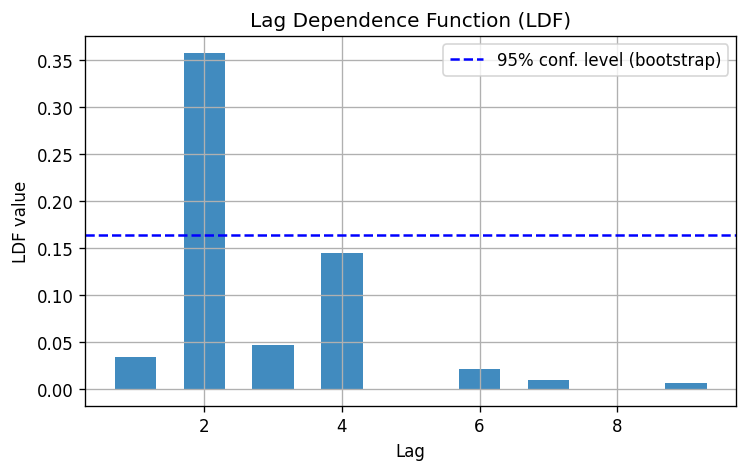

Significant lags (ldf > 95% line): [2]


In [6]:
best_idx = int(np.argmin([m.bic for m in models]))
best_model = models[best_idx]
best_order = orders[best_idx]
best_resid = residuals[best_idx]
print("Selected by BIC:", best_order, "AIC:", best_model.aic, "BIC:", best_model.bic)

lags = np.arange(1, 10)
ldf_vals, ldf_thresh = ldf_with_leaveoneout(best_resid, lags, n_boot=100, plot=True, plotFits=False)
sig_lags = [int(k) for k, v in zip(lags, ldf_vals) if v > ldf_thresh]
print("Significant lags (ldf > 95% line):", sig_lags)


In [ ]:
def n_step_residual_plot(e, n):
    e = np.asarray(e, float)
    if n <= 0 or n >= len(e): return
    plt.figure(figsize=(5,4))
    plt.scatter(e[:-n], e[n:], s=15, alpha=0.6)
    plt.axhline(0, color="gray", lw=1); plt.axvline(0, color="gray", lw=1)
    plt.xlabel(f"e[t-{n}]"); plt.ylabel("e[t]"); plt.title(f"{n}-step residuals vs residuals")
    slope, intercept, *_ = linregress(e[:-n], e[n:])
    xs = np.linspace(min(e), max(e), 200)
    plt.plot(xs, intercept + slope*xs, color="red", lw=2)
    if SAVE_PLOTS: plt.savefig(f"n_step_residuals_lag{n}.png", dpi=200, bbox_inches="tight")
    plt.show()

# Teacher asked 2-step and 4-step; also any significant lags we found:
for n in ([2,4] + [k for k in sig_lags if k not in (2,4)])[:4]:
    n_step_residual_plot(best_resid, n)
